# Identifying SRKW Orca Calls using CNN and SNN
## 00-Explore data and annotations
 Data source: https://github.com/orcasound/orcadata/wiki/Pod.Cast-data-archive

#### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile

##### Define directories

In [2]:
parentdir="../"
codedir=parentdir+"code/"
datadir=parentdir+"data/"
train_dir=datadir+"TrainDataLatest_PodCastAllRounds_123567910/"
test_dir=datadir+"TestDataLatest_PodCastAllRounds_123/"

#### Load raw data

In [3]:
f=os.path.join(train_dir,'annotations.tsv')
anno_table=pd.read_csv(f, sep='\t')
del(f)

#### Take a look at the table

In [4]:
anno_table.head(10)

,dataset,wav_filename,start_time_s,duration_s,location,date,pst_or_master_tape_identifier
0,podcast_round1,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",1960-10-28,60012
1,podcast_round1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",1960-10-28,60012
2,podcast_round1,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",1960-10-28,60012
3,podcast_round1,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",1960-10-28,60012
4,podcast_round1,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",1960-10-28,60012
5,podcast_round1,60012.wav,51.381,3.248,"Dabob Bay, Seattle, Washington",1960-10-28,60012
6,podcast_round1,60012.wav,59.196,2.106,"Dabob Bay, Seattle, Washington",1960-10-28,60012
7,podcast_round1,60012.wav,61.125,3.425,"Dabob Bay, Seattle, Washington",1960-10-28,60012
8,podcast_round1,60012.wav,70.590,6.546,"Dabob Bay, Seattle, Washington",1960-10-28,60012
9,podcast_round1,60012.wav,86.094,4.136,"Dabob Bay, Seattle, Washington",1960-10-28,60012


Check how many rounds of data are included in the training data

In [5]:
anno_table.dataset.value_counts()

podcast_round1     3139
podcast_round10     623
podcast_round3      496
podcast_round2      446
podcast_round9      287
podcast_round6      176
podcast_round7      167
podcast_round11     118
podcast_round12      54
podcast_round5       31
Name: dataset, dtype: int64

 Max and min of start time, duraton, and date. Every entry is a call starting at the start time and eand at start time + duration

In [6]:
print(f'Start time: Min={min(anno_table.start_time_s)}; Max={max(anno_table.start_time_s)}')
print(f'Duration: Min={min(anno_table.duration_s)}; Max={max(anno_table.duration_s)};') 
print(f'Date: {min(anno_table.date)} ~ {max(anno_table.date)};')

Start time: Min=0.0; Max=1550.552
Duration: Min=0.0; Max=16.558;
Date: 1958-02-19 ~ 2020_09_01;


Load a sample of the SRKW calls

In [6]:
ipd.Audio(train_dir+'wav/9774700N.wav')

 Make plots appear inline

In [7]:
%matplotlib inline 

 Plot the duration distribution

(array([2582., 2331.,  388.,  143.,   43.,   28.,    9.,    6.,    4.,
           3.]),
 array([ 0.    ,  1.6558,  3.3116,  4.9674,  6.6232,  8.279 ,  9.9348,
        11.5906, 13.2464, 14.9022, 16.558 ]),
 <BarContainer object of 10 artists>)

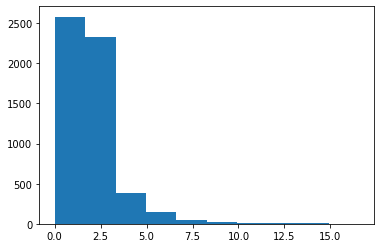

In [8]:
plt.hist(anno_table.duration_s)

 Entry with 0 duration indicate the file contains only negative sample

 Number of locations

In [89]:
anno_table.location.value_counts()

Oregon Coastal Aquarium, Newport, OR                                   1453
orcasound_lab                                                          1316
bush_point                                                              741
Kikvika, Norway                                                         472
port_townsend                                                           341
WHOIS                                                                   309
Vancouver, British Columbia                                             267
80 mi. south of Martha's Vineyard, Massachusetts                        264
Andenes, Norway                                                         156
Outside St. John's Hbr., Newfoundland                                    90
Saanich Inlet, Victoria, Vancouver Island, British Columbia, Canada      55
T3 Ice Island, Canada                                                    40
Dabob Bay, Seattle, Washington                                           33
Name: locati

Clean up the location

In [88]:
anno_table['location']=np.where(anno_table['location']=="Saanich Inlet, Victoria, VAncouver Island, British Columbia, Canada", 
    "Saanich Inlet, Victoria, Vancouver Island, British Columbia, Canada", 
    np.where(anno_table['location']=="80 mi. south of Martha's Vineyard, Massachusetts    X", 
        "80 mi. south of Martha's Vineyard, Massachusetts", 
        np.where(anno_table['location'].isin(['Oregon Coastal Aquarium, Newport, OR    X', 'Oregon Coast Aquarium']),
        'Oregon Coastal Aquarium, Newport, OR', anno_table['location'])))

Remove start_time and duration from anno_table and flatten the rest of the table

In [90]:
train_wav_dat=anno_table.drop(['start_time_s','duration_s'],axis=1).drop_duplicates(keep='last',ignore_index=True)

Load Test Data

In [11]:
f=os.path.join(test_dir,'test.tsv')
test_table=pd.read_csv(f, sep='\t')
del(f)

Check how many rounds of testing data are included

In [12]:
test_table.dataset.value_counts()

podcast_test_round1    523
podcast_test_round3    192
podcast_test_round2    113
Name: dataset, dtype: int64

Check locations of testing data

In [92]:
test_table.location.value_counts()

orcasound_lab    636
port_townsend    192
Name: location, dtype: int64

#### Find out length of wav files in the training folder

In [27]:
train_audiolist=list(set(os.listdir(train_dir+"wav/")))
train_audiolist=[i for i in train_audiolist if i.endswith('.wav') and not i.startswith('._')]

Create a helper function to read in wav file and return sample rate, length of file, and the audio data

In [16]:
def readinwav(wav_file):
    rate, audio=wavfile.read(wav_file)
    wavdur=audio.shape[0]/rate
    return rate, wavdur, audio

Create a dictionary where the key is the name of the training wav file and value the length

In [29]:
train_wav_dict={}
for w in train_audiolist:
    _,train_wav_dict[w],_=readinwav(os.path.join(train_dir,"wav",w))

Get the range of min and max of the wav duration

In [106]:
print(f'wav duration: min={min(train_wav_dict.values())}; max={max(train_wav_dict.values())}')

wav duration: min=0.1213; max=1969.09095


The data contain both large and small wav files. We will split up the data into short and long piles. before plotting the duration.

In [37]:
train_wav_dict_long={k:v for k,v in train_wav_dict.items() if v>=40}
train_wav_dict_short={k:v for k,v in train_wav_dict.items() if v<40}

(array([772.,   1.,   4.,   1.,   0.,   0.,   0.,   1.,   1.,   2.]),
 array([  52.37333333,  244.045095  ,  435.71685667,  627.38861833,
         819.06038   , 1010.73214167, 1202.40390333, 1394.075665  ,
        1585.74742667, 1777.41918833, 1969.09095   ]),
 <BarContainer object of 10 artists>)

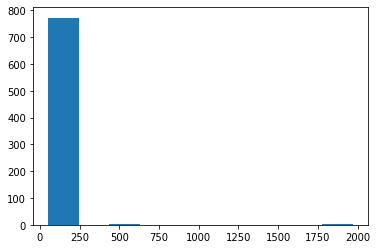

In [38]:
plt.hist(train_wav_dict_long.values())

In the long pile, the majority of the wav files are 50+ seconds with a few outliers like the ones below.  

In [96]:
for k,v in train_wav_dict_long.items():
    if v>62:
        lookup_d=train_wav_dat[train_wav_dat['wav_filename']=='60026.wav'][['dataset','location','date']]
        print(k,str(round(v/60, 2))+'min', lookup_d.iloc[0,0],lookup_d.iloc[0,1],lookup_d.iloc[0,2])
del(lookup_d)

61062.wav 32.43min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
64030.wav 8.07min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
64023.wav 8.23min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
64020.wav 8.22min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
64031.wav 13.06min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
66049.wav 32.82min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
64025.wav 8.2min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
79015.wav 25.1min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
60012.wav 5.95min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21
60026.wav 29.0min podcast_round1 80 mi. south of Martha's Vineyard, Massachusetts 1960-12-21


The files with more than one minute (to be precise >62 seconds) are all from Round 1 of the PodCast data archive from 80 milessouth of Martha's Vineyeard Massachusetts back in 1960.

In [101]:
train_wav_dict_long={k:v for k,v in train_wav_dict.items() if v>62}
train_wav_dict_medium={k:v for k,v in train_wav_dict.items() if v>=40 and v<=62}

(array([5., 0., 1., 0., 0., 0., 0., 1., 1., 2.]),
 array([ 356.7002  ,  517.939275,  679.17835 ,  840.417425, 1001.6565  ,
        1162.895575, 1324.13465 , 1485.373725, 1646.6128  , 1807.851875,
        1969.09095 ]),
 <BarContainer object of 10 artists>)

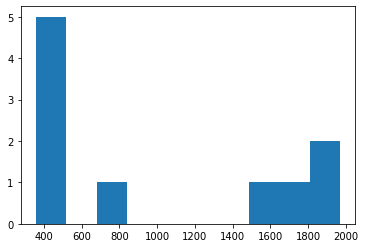

In [102]:
plt.hist(train_wav_dict_long.values())

(array([  1.,   5.,   2.,   0.,   1.,   3.,   4.,   1., 521., 234.]),
 array([52.37333333, 53.261     , 54.14866667, 55.03633333, 55.924     ,
        56.81166667, 57.69933333, 58.587     , 59.47466667, 60.36233333,
        61.25      ]),
 <BarContainer object of 10 artists>)

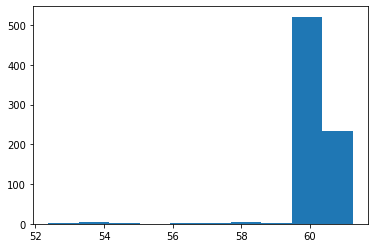

In [103]:
plt.hist(train_wav_dict_medium.values())

(array([1.196e+03, 5.730e+02, 1.760e+02, 7.200e+01, 3.300e+01, 1.900e+01,
        6.000e+00, 3.000e+00, 1.000e+00, 2.000e+00]),
 array([ 0.1213  ,  1.765065,  3.40883 ,  5.052595,  6.69636 ,  8.340125,
         9.98389 , 11.627655, 13.27142 , 14.915185, 16.55895 ]),
 <BarContainer object of 10 artists>)

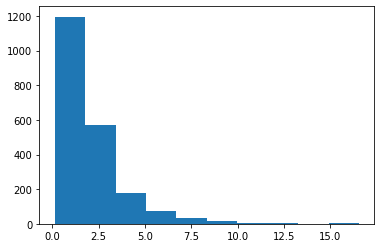

In [39]:
plt.hist(train_wav_dict_short.values())

The wav files from the training datasets can be categorized into three piles based on its length:
1) long: 6min to 33min (n=10)
2) medium: 52s to 62s (n=772)
3) short: 0.12s to 16s (n=2081)

#### Find out length of wav files in the testing folder

In [104]:
test_audiolist=list(set(os.listdir(test_dir+"wav/")))
test_audiolist=[i for i in test_audiolist if i.endswith('.wav') and not i.startswith('._')]

Create a dictionary where the key is the name of the testing wav file and value the length

In [105]:
test_wav_dict={}
for w in test_audiolist:
    _,test_wav_dict[w],_=readinwav(os.path.join(test_dir,"wav",w))

Find the min and max of the wav file duration of the testing dataset 

In [107]:
print(f'wav duration: min={min(test_wav_dict.values())}; max={max(test_wav_dict.values())}')

wav duration: min=51.733333333333334; max=1800.16


Unlike the training data, there is no super short samples. 

In [108]:
test_wav_dict_long={k:v for k,v in test_wav_dict.items() if v>62}
test_wav_dict_medium={k:v for k,v in test_wav_dict.items() if v<=62}

(array([ 3.,  1.,  7.,  0.,  1.,  5.,  4.,  0., 69., 21.]),
 array([51.73333333, 52.685     , 53.63666667, 54.58833333, 55.54      ,
        56.49166667, 57.44333333, 58.395     , 59.34666667, 60.29833333,
        61.25      ]),
 <BarContainer object of 10 artists>)

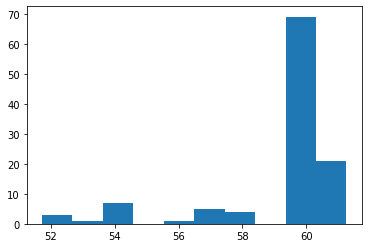

In [110]:
plt.hist(test_wav_dict_medium.values())

In [109]:
test_wav_dict_long.keys()

dict_keys(['OS_7_05_2019_08_24_00_.wav'])

The testing samples can be categorized into two groups:
1) long: 30min (n=1) file name "OS_7_05_2019_08_24_00_.wav"
2) medium: 52s to 61s (n=111)